### Import libraries

In [15]:
import numpy as np
import pandas as pd
import csv
import time

#Scikit-Learn Machine Learning 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import pylab as pl
import matplotlib.pyplot as pl
from sklearn.preprocessing import scale
from sklearn import metrics

#Seaborn 
pl.style.use('fivethirtyeight')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read in csv file into pandas dataframe
student_data = pd.read_csv("student-data.csv")
print ("Student data read successfully!")

Student data read successfully!


In [3]:
#return the first 5 rows (all columns)
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


### Exploratory Analysis

In [4]:
#Dimensions of Data 
n_students = student_data.shape[0] #number of students (rows)
n_features = student_data.shape[1]-1 #number of features (columns)
print("Total Number of Students: {}".format(n_students))
print("Total Number of Features: {}".format(n_features))

Total Number of Students: 395
Total Number of Features: 30


In [5]:
n_passed =  student_data[student_data['passed'] =='yes'].shape[0]
n_failed =  student_data[student_data['passed'] == 'no'].shape[0]
grad_rate = (n_passed*1.0) / (n_students*1.0) * 100

print("Number of students who passed: {}".format(n_passed))
print("Number of students who failed: {}".format(n_failed))
print("Number of features: {}".format(n_features))
print("Graduation rate of the class: {:.2f}%".format(float(grad_rate)))

Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


In [6]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print("Feature column(s):{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
#print X_all.head()  # print the first 5 rows

Feature column(s):['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed


In [7]:
# Preprocess feature columns
def preprocess_features(X):
    df_preprocess = pd.DataFrame(index=X.index) # output dataframe, initially empty
    # iterate through each column
    for colname, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object: #if data type == object (i.e. non-numeric)
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # If data is non-numeric and consist of more than 2 level
        # convert todummy variables (indicator variables)
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=colname)  
        #join columns to one dataframe
        df_preprocess = df_preprocess.join(col_data)  # collect column(s) in output dataframe
    return df_preprocess

X_all = preprocess_features(X_all)
print("Processed Feature Columns")
X_all.head()

Processed Feature Columns


,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,1,0,1,0,18,0,1,1,0,1,...,1,0,0,4,3,4,1,1,3,6
1,1,0,1,0,17,0,1,1,0,0,...,1,1,0,5,3,3,1,1,3,4
2,1,0,1,0,15,0,1,0,1,0,...,1,1,0,4,3,2,2,3,3,10
3,1,0,1,0,15,0,1,1,0,0,...,1,1,1,3,2,2,1,1,5,2
4,1,0,1,0,16,0,1,1,0,0,...,1,0,0,4,3,2,1,2,5,4


In [8]:
#Format Target yes/no values with 1/0
y = pd.DataFrame(y_all, index = y_all.index)
y = y.replace(['yes','no'], [1, 0]) 
#in the form (X, 1), but the method expects a 1d array and has to be in the form (X, )

#join dataset
df_data = pd.concat([X_all, y], axis = 1)
df_data.head() #passed --> response variable

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,1,0,1,0,18,0,1,1,0,1,...,0,0,4,3,4,1,1,3,6,0
1,1,0,1,0,17,0,1,1,0,0,...,1,0,5,3,3,1,1,3,4,0
2,1,0,1,0,15,0,1,0,1,0,...,1,0,4,3,2,2,3,3,10,1
3,1,0,1,0,15,0,1,1,0,0,...,1,1,3,2,2,1,1,5,2,1
4,1,0,1,0,16,0,1,1,0,0,...,0,0,4,3,2,1,2,5,4,1


In [9]:
df_data.describe()
#statistics from df1 dataframe

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,...,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,0.883544,0.116456,0.526582,0.473418,16.696203,0.222785,0.777215,0.711392,0.288608,0.103797,...,0.832911,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,0.670886
std,0.321177,0.321177,0.499926,0.499926,1.276043,0.416643,0.416643,0.453690,0.453690,0.305384,...,0.373528,0.472300,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,0.470487
min,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,16.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,17.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000,18.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,1.000000


In [10]:
#Data Correlation:
df = df_data.corr()
corr_target = df.ix[-1][:-1] #Target is last column in the DataFrame
predict = corr_target.sort_values(ascending=False)
df_sort = corr_target.sort_values(ascending=False)
print(df_sort)

higher               0.157708
Medu                 0.115396
Fedu                 0.108057
paid                 0.092665
Mjob_health          0.080484
studytime            0.074613
sex_M                0.070618
reason_reputation    0.067771
internet             0.061791
Mjob_services        0.060114
guardian_father      0.059347
reason_other         0.053316
Fjob_teacher         0.052557
address_U            0.052282
famrel               0.046683
Pstatus_A            0.044050
famsize_LE3          0.041842
school_GP            0.031254
Fjob_other           0.026180
activities           0.012414
guardian_mother      0.009890
Mjob_teacher         0.001349
reason_home         -0.001526
Fjob_health         -0.001962
nursery             -0.008784
freetime            -0.018321
Walc                -0.029957
school_MS           -0.031254
Fjob_at_home        -0.034839
Mjob_at_home        -0.039031
Fjob_services       -0.041572
famsize_GT3         -0.041842
Pstatus_T           -0.044050
traveltime

c:\users\shreyansh jain\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


### Split Data Into Training/Testing Sets

In [18]:
def Stratified_Shuffle_Split(X,y,num_test):
    sss = StratifiedShuffleSplit(y, 1, test_size=num_test, random_state = None)
    for train, test in sss:
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
    return X_train, X_test, y_train, y_test

# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = round(num_all*0.75)  # about 75% of the data
num_test = num_all - num_train
#print(num_test)

y = student_data['passed'] # identify target variable
X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y, num_test)

print("Training Set: {0:.2f} Samples".format(X_train.shape[0]))
print("Testing Set: {0:.2f} Samples".format(X_test.shape[0]))

Training Set: 296.00 Samples


Testing Set: 99.00 Samples

### Train Model

In [12]:
def train_classifier(clf, X_train, y_train):
    start = time.time() #specifty start time
    
    clf.fit(X_train, y_train) #train model
    
    end = time.time() #specify end time
    train_clf_time = end - start #total training time
    print("Total Training Time (secs): {:.3f}".format(train_clf_time))
    return train_clf_time 

### Make Prediction on Training Set & Compute F1 Score

In [17]:
def predict_labels(clf, features, target):
    start = time.time() #start prediction time
    y_pred = clf.predict(features) #prediction 
    end = time.time() # stop prediction time
    prediction_time = end - start # total prediction time
    print("Prediction Time (secs): {:.3f}".format(prediction_time))
    
    p,r,f,s = precision_recall_fscore_support(target.values,
              y_pred, average='binary', pos_label='yes')
    print("Precision Score: {0:.4f}".format(p))
    print("Recall Score: {0:.4f}".format(r))
    print("F1 Score: {0:.4f}".format(f))
    return(y_pred)

In [18]:
#Feature Selection --> Random Forest
def feature_importance(clf):
    # Relative Importance (Features)
    clf.fit(X_train,y_train)
    # Get Feature Importance from the classifier
    feature_importance = clf.feature_importances_
    # Normalize The Features
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    # Sort Features and Creat Horizontal Bar Plot
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    pl.figure(figsize=(16, 12))
    pl.barh(pos, feature_importance[sorted_idx], align='center', color='#0033CC')
    pl.yticks(pos, np.asanyarray(df.columns.tolist())[sorted_idx])
    pl.xlabel("Relative Importance")
    pl.title("Variable Importance - Random Forest")
    pl.show()

### Train and Predict



Model: GaussianNB


**********************************************************
**Training**
Data Size: 296
Total Training Time (secs): 0.000
Prediction Time (secs): 0.000
Precision Score: 0.7897
Recall Score: 0.8492
F1 Score: 0.8184
**********************************************************
**Testing**
Data Size: 99
Prediction Time (secs): 0.000
Precision Score: 0.7500
Recall Score: 0.7273
F1 Score: 0.7385


Model: SVC


**********************************************************
**Training**
Data Size: 296
Total Training Time (secs): 0.016
Prediction Time (secs): 0.000
Precision Score: 0.7743
Recall Score: 1.0000
F1 Score: 0.8728
**********************************************************
**Testing**
Data Size: 99
Prediction Time (secs): 0.000
Precision Score: 0.7045
Recall Score: 0.9394
F1 Score: 0.8052


Model: RandomForestClassifier


**********************************************************
**Training**
Data Size: 296
Total Training Time (secs): 0.889
Prediction Time (secs): 0.04

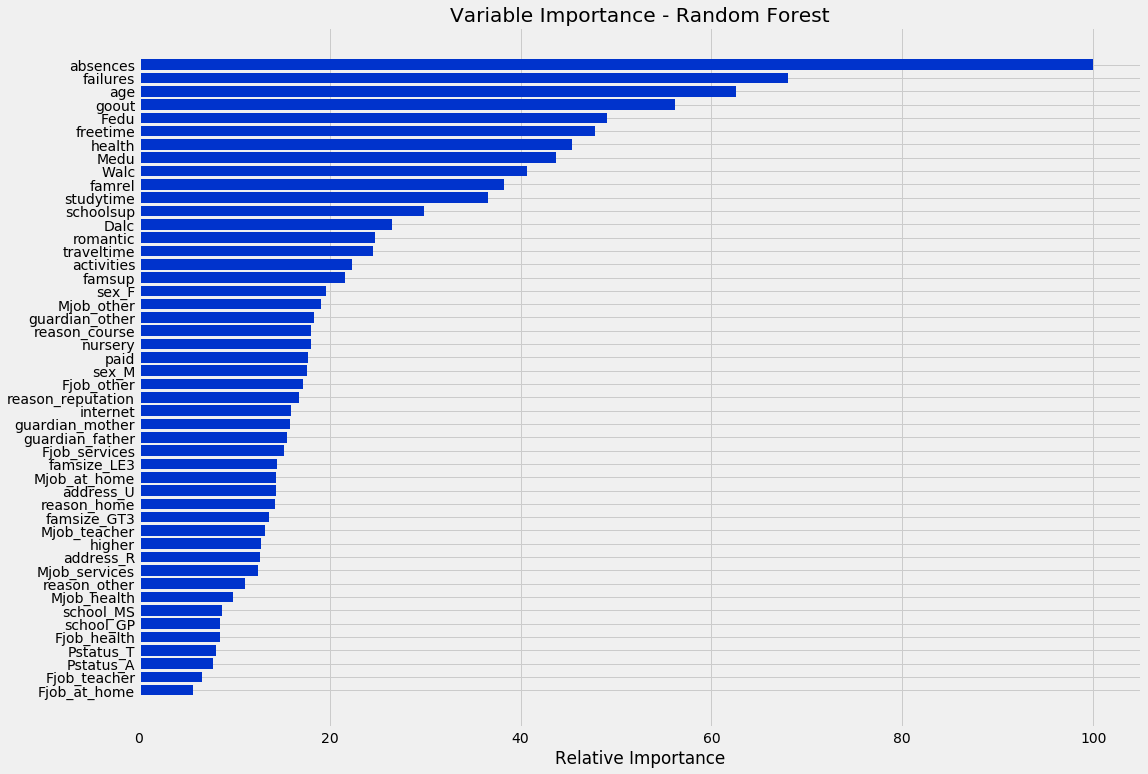

In [27]:
clf_NB = GaussianNB()
clf_SVC = SVC()
clf_RF = RandomForestClassifier(n_estimators = 500)

algorithms = [clf_NB,clf_SVC,clf_RF]

for model in algorithms:
    print("\n")
    print("==============================")
    print("Model: {}".format(model.__class__.__name__))
    print("==============================")
    print("\n")
    print("**********************************************************")
    print("**Training**")
    print("Data Size:",len(X_train))
    # Fit model to training data
    train_classifier(model, X_train, y_train)

    # Predict on training set and compute F1 score
    predict_labels(model, X_train, y_train)

    #Predict on Testing Data
    print("**********************************************************")
    print("**Testing**")
    print("Data Size:",len(X_test))
    predict_labels(model, X_test, y_test)
    
    if model == clf_RF:
        print("\n")
        feature_importance(clf_RF)

In [13]:
# Fine-tune the model and report the best F1 score
def iterate_fit_predict(n,X_train, y_train,X_test,y_test):
        f1_scores = []
        gamma = []
        C = []
        
        y_train = y_train.replace(['yes', 'no'], [1, 0])
        y_test = y_test.replace(['yes', 'no'], [1, 0])
        
        for num in range(0,n):
            clf_SVC = SVC()
            
            #Gridsearch -- checking combinations for hyperparameters
            parameters = [{'C':[1,10,50,100,200,300,400,500,1000],
                         'gamma':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
                         'kernel': ['rbf']}]
            
            clf = GridSearchCV(clf_SVC, parameters, scoring = 'f1')
            
            #Fit the learner to the training data to obtain the best parameter set
            clf.fit(X_train,y_train)
            
            # get f1 scores, append to df
            f1_scores.append(clf.score(X_test, y_test))
            
            #get best gamma
            gamma.append(clf.best_params_['gamma'])
            
            #get best 'C'
            C.append(clf.best_params_['C'])
            
            #get best estimator
            clf = clf.best_estimator_
            #print clf
        
        
        df_f1 = pd.Series(f1_scores)
        df_gamma = pd.Series(gamma)
        df_C = pd.Series(C)
        
        print("Classifier: {}".format(clf.__class__.__name__))
        print("\nF1 Scores:")
        print(df_f1)

        print("\nAverage F1 Test Scores:")
        print(df_f1.mean())
        print("\nAverage C:")
        print(df_C.mean())
        print("\nAverage Gamma:")
        print(df_gamma.mean())

In [16]:
iterate_fit_predict(1,X_train, y_train,X_test,y_test)

Classifier: SVC

F1 Scores:
0    0.802469
dtype: float64

Average F1 Test Scores:
0.8024691358024691

Average C:
1.0

Average Gamma:
0.1